In [49]:
import pandas as pd

In [51]:
import matplotlib.pyplot as plt

In [53]:
df = pd.read_csv('merged_climate_data.csv')
print(df.head())

         Date  Latitude  Longitude  tmin   tmax  rain
0  1990-01-01      24.5       85.5  8.48  21.35   0.0
1  1990-01-02      24.5       85.5  7.84  20.53   0.0
2  1990-01-03      24.5       85.5  7.04  20.32   0.0
3  1990-01-04      24.5       85.5  5.83  20.83   0.0
4  1990-01-05      24.5       85.5  6.35  22.27   0.0


In [55]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df['Tmean'] = (df['tmax'] + df['tmin']) / 2
print(df.head())

        Date  Latitude  Longitude  tmin   tmax  rain   Tmean
0 1990-01-01      24.5       85.5  8.48  21.35   0.0  14.915
1 1990-01-02      24.5       85.5  7.84  20.53   0.0  14.185
2 1990-01-03      24.5       85.5  7.04  20.32   0.0  13.680
3 1990-01-04      24.5       85.5  5.83  20.83   0.0  13.330
4 1990-01-05      24.5       85.5  6.35  22.27   0.0  14.310


In [57]:
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
grid_normal = df.groupby(['Latitude', 'Longitude','Month', 'Day'])[['tmax','Tmean','tmin']].mean().reset_index()
grid_normal.rename(columns={
    'tmax': 'Tmax_11yr_avg',
    'Tmean': 'Tmean_11yr_avg',
    'tmin': 'Tmin_11yr_avg'
}, inplace=True)
grid_normal = grid_normal.sort_values(by='Latitude', ascending=False)
print(grid_normal.head())

      Latitude  Longitude  Month  Day  Tmax_11yr_avg  Tmean_11yr_avg  \
7271      25.5       88.5     11   13      29.467590       23.388829   
7283      25.5       88.5     11   25      28.233274       21.610413   
7319      25.5       88.5     12   31      24.159906       17.284565   
7318      25.5       88.5     12   30      24.270687       17.201847   
7317      25.5       88.5     12   29      23.758726       17.023931   

      Tmin_11yr_avg  
7271      17.310068  
7283      14.987552  
7319      10.409223  
7318      10.133006  
7317      10.289135  


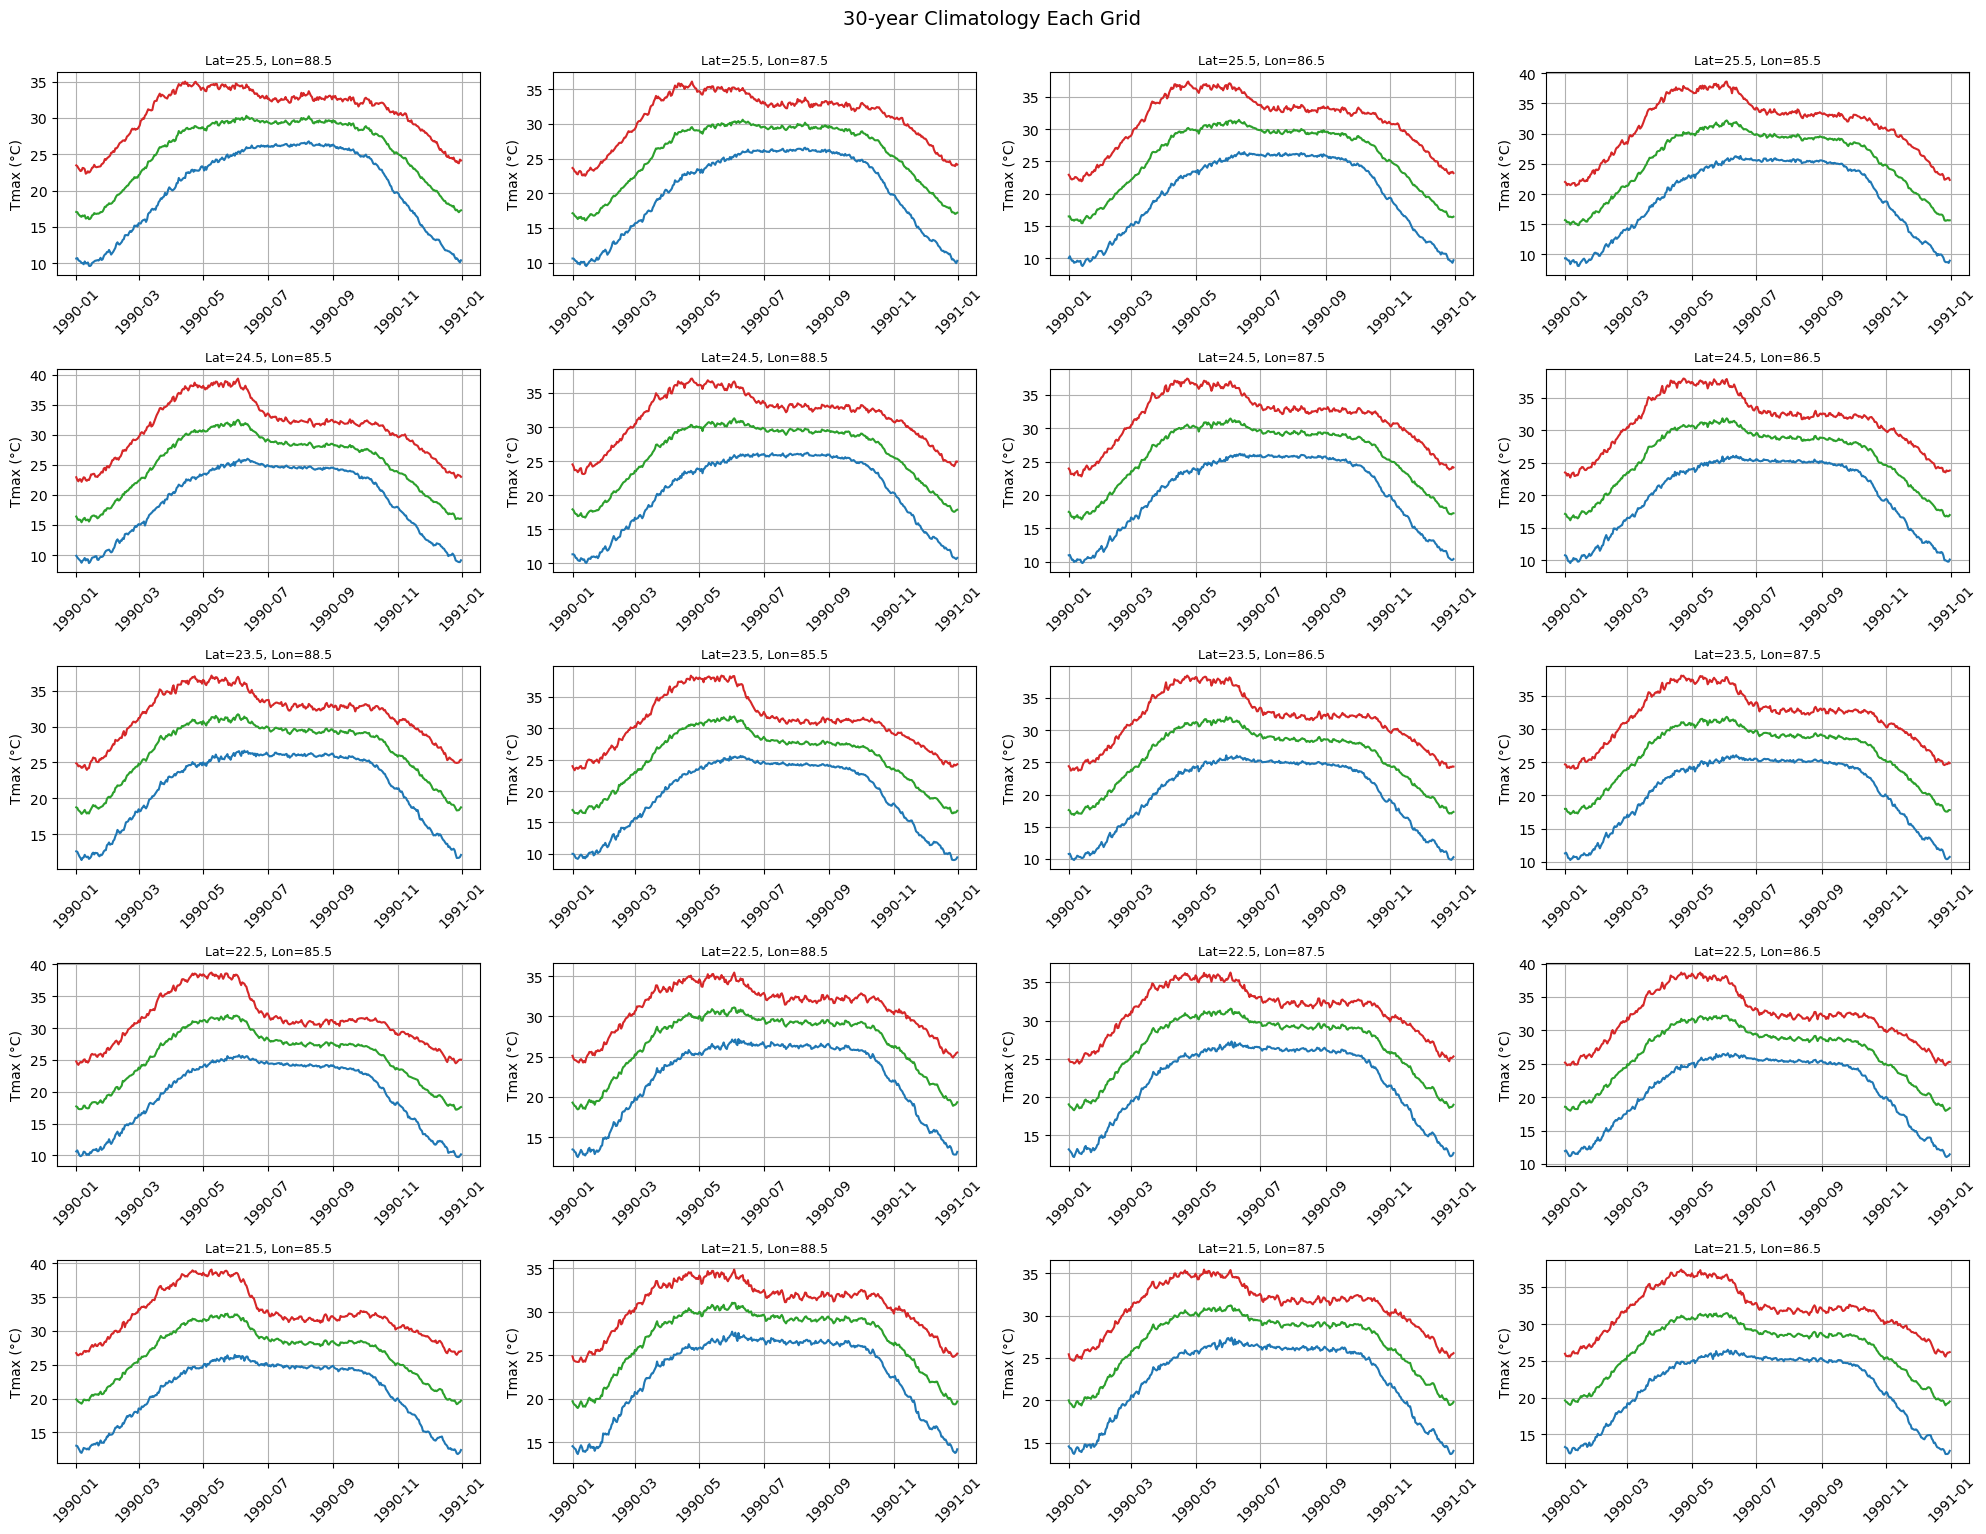

In [61]:

grid_normal['Date'] = pd.to_datetime(
    '1990-' + grid_normal['Month'].astype(str).str.zfill(2) + '-' + grid_normal['Day'].astype(str).str.zfill(2),
    errors='coerce'  # invalid dates will become NaT
)
grid_points = grid_normal[['Latitude', 'Longitude']].drop_duplicates().values
n = len(grid_points)
cols = 4  
rows = -(-n // cols)  
plt.figure(figsize=(cols*5, rows*3))

for i, (lat, lon) in enumerate(grid_points):
    subset = grid_normal[(grid_normal['Latitude'] == lat) & (grid_normal['Longitude'] == lon)]
    subset = subset.sort_values('Date')

    ax = plt.subplot(rows, cols, i+1)
    ax.plot(subset['Date'], subset['Tmax_11yr_avg'], color='tab:red')
    ax.plot(subset['Date'], subset['Tmin_11yr_avg'], color='tab:blue')
    ax.plot(subset['Date'], subset['Tmean_11yr_avg'], color='tab:green')
    ax.set_title(f'Lat={lat}, Lon={lon}', fontsize=9)
    ax.set_xlabel('')
    ax.set_ylabel('Tmax (°C)')
    ax.tick_params(axis='x', labelrotation=45)
    plt.grid(True)

plt.tight_layout()
plt.suptitle('30-year Climatology Each Grid ', fontsize=14, y=1.02)
plt.show()

In [24]:
'''df_merged = pd.merge(
    df,
    grid_normal,
    on=['Latitude', 'Longitude', 'Month', 'Day'],
    how='left'
)

#df_merged = df_merged.sort_values(by='Latitude', ascending=False)

#df['Month'] = df['Date'].dt.month
#df['Day'] = df['Date'].dt.day
#df_merged = pd.merge(df, grid_avg_tmean, on=['Latitude', 'Longitude', 'Month', 'Day'], how='left')

df_merged.rename(columns={'Date_x': 'Date', 'Date_y': 'Climatology_Date'}, inplace=True)
print(df_merged.head())
df_merged.to_csv('All_normals.csv', index=False)

grid_points = df_merged[['Latitude', 'Longitude']].drop_duplicates().sort_values(by='Latitude', ascending=False).values
years = sorted(df_merged['Date'].dt.year.unique())

for year in years:
    fig, axs = plt.subplots(5, 4, figsize=(20, 20))  # 5 rows, 4 columns
    fig.suptitle(f'Actual vs Climatology - Tmax, Tmin, Tmean (Year: {year})', fontsize=20)

    for i, (lat, lon) in enumerate(grid_points):
        ax = axs[i // 4, i % 4]
        
        df_plot = df_merged[
            (df_merged['Latitude'] == lat) &
            (df_merged['Longitude'] == lon) &
            (df_merged['Date'].dt.year == year)
        ]

        # Plot actual and climatology
        ax.plot(df_plot['Date'], df_plot['tmax'], label='Tmax', color='tab:red')
        ax.plot(df_plot['Date'], df_plot['Tmax_11yr_avg'], linestyle='--', label='Tmax Climatology', color='tab:red', alpha=0.5)
        
        #ax.plot(df_plot['Date'], df_plot['Tmin'], label='Tmin', color='tab:green')
        #ax.plot(df_plot['Date'], df_plot['Tmin_11yr_avg'], linestyle='--', label='Tmin Climatology', color='tab:green', alpha=0.5)

        #ax.plot(df_plot['Date'], df_plot['Tmean'], label='Tmean', color='tab:blue')
        ax.plot(df_plot['Date'], df_plot['Tmean_11yr_avg'], linestyle='--', label='Tmean Climatology', color='tab:gray', alpha=0.5)

        ax.set_title(f'({lat}, {lon})', fontsize=9)
        ax.tick_params(axis='x', labelrotation=45)
        ax.set_aspect('auto')  # Equal aspect may squash the graph too much
        ax.grid(True)

        if i == 0:
            ax.legend(fontsize=8)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()'''

"df_merged = pd.merge(\n    df,\n    grid_normal,\n    on=['Latitude', 'Longitude', 'Month', 'Day'],\n    how='left'\n)\n\n#df_merged = df_merged.sort_values(by='Latitude', ascending=False)\n\n#df['Month'] = df['Date'].dt.month\n#df['Day'] = df['Date'].dt.day\n#df_merged = pd.merge(df, grid_avg_tmean, on=['Latitude', 'Longitude', 'Month', 'Day'], how='left')\n\ndf_merged.rename(columns={'Date_x': 'Date', 'Date_y': 'Climatology_Date'}, inplace=True)\nprint(df_merged.head())\ndf_merged.to_csv('All_normals.csv', index=False)\n\ngrid_points = df_merged[['Latitude', 'Longitude']].drop_duplicates().sort_values(by='Latitude', ascending=False).values\nyears = sorted(df_merged['Date'].dt.year.unique())\n\nfor year in years:\n    fig, axs = plt.subplots(5, 4, figsize=(20, 20))  # 5 rows, 4 columns\n    fig.suptitle(f'Actual vs Climatology - Tmax, Tmin, Tmean (Year: {year})', fontsize=20)\n\n    for i, (lat, lon) in enumerate(grid_points):\n        ax = axs[i // 4, i % 4]\n        \n        df_pl

In [34]:
'''daily_avg = df.groupby('Date')[['tmax', 'Tmean', 'tmin']].mean().reset_index()
daily_avg.rename(columns={
    'tmax': 'Tmax_avg_all_grids',
    'Tmean': 'Tmean_avg_all_grids',
    'tmin': 'Tmin_avg_all_grids'
}, inplace=True)

plt.figure(figsize=(14, 6))
plt.plot(daily_avg['Date'], daily_avg['Tmax_avg_all_grids'], label='Tmax Avg', color='tab:red', linewidth=0.8)
plt.plot(daily_avg['Date'], daily_avg['Tmean_avg_all_grids'], label='Tmean Avg', color='tab:green', linewidth=0.8)
plt.plot(daily_avg['Date'], daily_avg['Tmin_avg_all_grids'], label='Tmin Avg', color='tab:blue', linewidth=0.8)
plt.title('Daily Average Temperature Across All 20 Grid Points (30 Years)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()'''

"daily_avg = df.groupby('Date')[['tmax', 'Tmean', 'tmin']].mean().reset_index()\ndaily_avg.rename(columns={\n    'tmax': 'Tmax_avg_all_grids',\n    'Tmean': 'Tmean_avg_all_grids',\n    'tmin': 'Tmin_avg_all_grids'\n}, inplace=True)\n\nplt.figure(figsize=(14, 6))\nplt.plot(daily_avg['Date'], daily_avg['Tmax_avg_all_grids'], label='Tmax Avg', color='tab:red', linewidth=0.8)\nplt.plot(daily_avg['Date'], daily_avg['Tmean_avg_all_grids'], label='Tmean Avg', color='tab:green', linewidth=0.8)\nplt.plot(daily_avg['Date'], daily_avg['Tmin_avg_all_grids'], label='Tmin Avg', color='tab:blue', linewidth=0.8)\nplt.title('Daily Average Temperature Across All 20 Grid Points (30 Years)')\nplt.xlabel('Date')\nplt.ylabel('Temperature (°C)')\nplt.legend()\nplt.grid(True)\nplt.tight_layout()\nplt.show()"

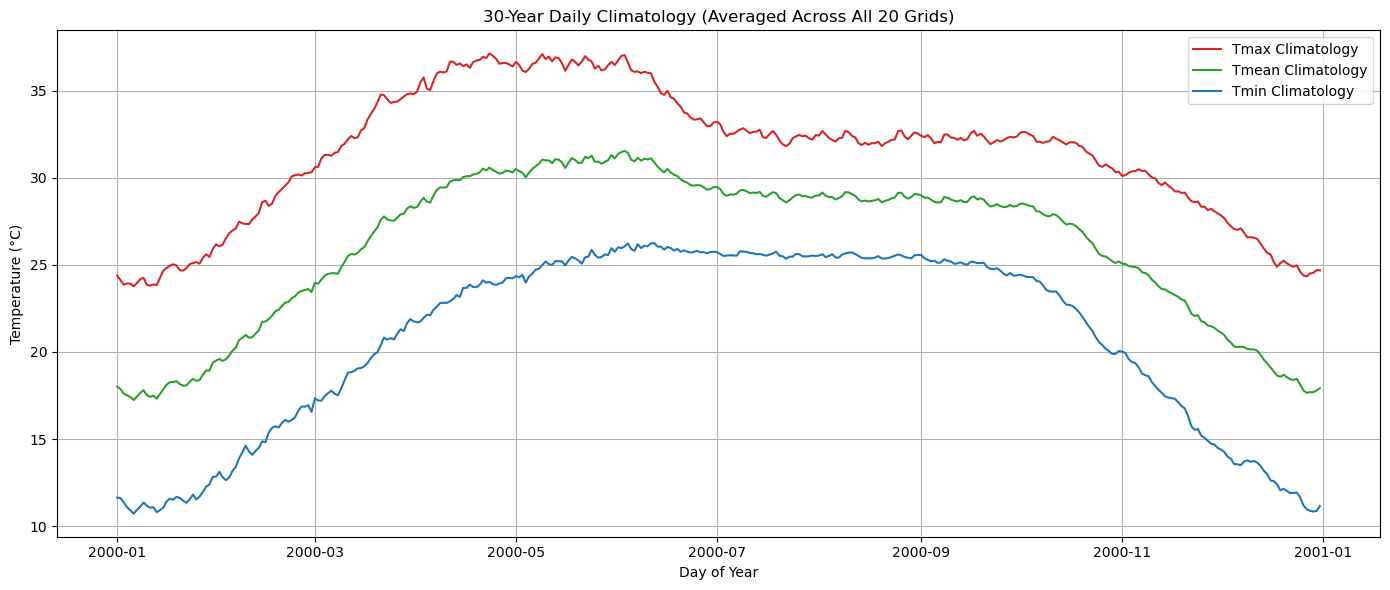

In [10]:
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

# Group by calendar day (Month + Day) and compute spatial average (over all grids) and temporal average (over 30 years)
climatology = df.groupby(['Month', 'Day'])[['tmax', 'tmin', 'Tmean']].mean().reset_index()

# Optional: Create a fake date for plotting
climatology['ClimoDate'] = pd.to_datetime('2000-' + climatology['Month'].astype(str).str.zfill(2) + '-' + climatology['Day'].astype(str).str.zfill(2))

# Plot
plt.figure(figsize=(14, 6))
plt.plot(climatology['ClimoDate'], climatology['tmax'], label='Tmax Climatology', color='tab:red')
plt.plot(climatology['ClimoDate'], climatology['Tmean'], label='Tmean Climatology', color='tab:green')
plt.plot(climatology['ClimoDate'], climatology['tmin'], label='Tmin Climatology', color='tab:blue')
plt.title('30-Year Daily Climatology (Averaged Across All 20 Grids)')
plt.xlabel('Day of Year')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
print(df.head())

        Date  Latitude  Longitude  tmin   tmax  rain   Tmean  Month  Day
0 1990-01-01      24.5       85.5  8.48  21.35   0.0  14.915      1    1
1 1990-01-02      24.5       85.5  7.84  20.53   0.0  14.185      1    2
2 1990-01-03      24.5       85.5  7.04  20.32   0.0  13.680      1    3
3 1990-01-04      24.5       85.5  5.83  20.83   0.0  13.330      1    4
4 1990-01-05      24.5       85.5  6.35  22.27   0.0  14.310      1    5


In [12]:
df = pd.read_csv('merged_climate_data.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

df['Tmean'] = (df['tmax'] + df['tmin']) / 2

grid_normal = df.groupby(['Latitude', 'Longitude', 'Month', 'Day'])[['Tmean']].mean().reset_index()
grid_normal.rename(columns={'Tmean': 'climatology'}, inplace=True)
#print(grid_normal.head())

df = pd.merge(df, grid_normal, on=['Latitude', 'Longitude', 'Month', 'Day'], how='left')


df['Tmax_diff'] = df['tmax'] - df['climatology']

df['Heatwave'] = (df['tmax'] > 40) & (df['Tmax_diff'] > 4.5)

heatwave_counts = df[df['Heatwave']].groupby(['Latitude', 'Longitude', 'Year']).size().reset_index(name='Heatwave_Days')

print(heatwave_counts)

     Latitude  Longitude  Year  Heatwave_Days
0        21.5       85.5  1990              2
1        21.5       85.5  1991             13
2        21.5       85.5  1992              6
3        21.5       85.5  1993              6
4        21.5       85.5  1994             12
..        ...        ...   ...            ...
376      25.5       87.5  1995              6
377      25.5       87.5  2010              1
378      25.5       87.5  2014              2
379      25.5       87.5  2016              2
380      25.5       88.5  1992              4

[381 rows x 4 columns]


In [13]:
import numpy as np

In [14]:
# Step 1: Heat wave classification
conditions = [
    (df['tmax'] > 40) & (df['Tmax_diff'] >= 4.5) & (df['Tmax_diff'] <= 6.4),
    (df['tmax'] > 40) & (df['Tmax_diff'] > 6.4)
]

choices = ['Heat Wave', 'Severe Heat Wave']

df['Heatwave_Type'] = np.select(conditions, choices, default='No Heat Wave')

# Step 2: Count number of days of each type per grid per year
heatwave_counts = df[df['Heatwave_Type'] != 'No Heat Wave'].groupby(
    ['Latitude', 'Longitude', 'Year', 'Heatwave_Type']
).size().reset_index(name='Days')

# Step 3: Pivot if you want Heat Wave and Severe Heat Wave counts side by side
heatwave_summary = heatwave_counts.pivot_table(
    index=['Latitude', 'Longitude', 'Year'],
    columns='Heatwave_Type',
    values='Days',
    fill_value=0
).reset_index()

# Optional: Rename columns for clarity
heatwave_summary.columns.name = None
heatwave_summary.rename(columns={
    'Heat Wave': 'Heatwave_Days',
    'Severe Heat Wave': 'Severe_Heatwave_Days'
}, inplace=True)

# Display final summary
print(heatwave_summary)


     Latitude  Longitude  Year  Severe_Heatwave_Days
0        21.5       85.5  1990                   2.0
1        21.5       85.5  1991                  13.0
2        21.5       85.5  1992                   6.0
3        21.5       85.5  1993                   6.0
4        21.5       85.5  1994                  12.0
..        ...        ...   ...                   ...
376      25.5       87.5  1995                   6.0
377      25.5       87.5  2010                   1.0
378      25.5       87.5  2014                   2.0
379      25.5       87.5  2016                   2.0
380      25.5       88.5  1992                   4.0

[381 rows x 4 columns]


In [36]:
df = pd.read_csv('merged_climate_data.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Tmean'] = (df['tmax'] + df['tmin']) / 2
grid_normal = df.groupby(['Latitude', 'Longitude', 'Month', 'Day'])[['Tmean']].mean().reset_index()
grid_normal.rename(columns={'Tmean': 'climatology'}, inplace=True)
df = df[(df['Year'] >= 1990) & (df['Year'] <= 2023)]
df = pd.merge(df, grid_normal, on=['Latitude', 'Longitude', 'Month', 'Day'], how='left')
df['Tmax_diff'] = df['tmax'] - df['climatology']
df['Heatwave_Type'] = 'No Heatwave'
df.loc[(df['tmax'] > 40) & (df['Tmax_diff'] >= 4.5) & (df['Tmax_diff'] <= 6.4), 'Heatwave_Type'] = 'Heatwave'
df.loc[(df['tmax'] > 40) & (df['Tmax_diff'] > 6.4), 'Heatwave_Type'] = 'Severe Heatwave'

# Group and count heatwave types per grid per year
heatwave_summary = df[df['Heatwave_Type'] != 'No Heatwave']
summary = heatwave_summary.groupby(['Latitude', 'Longitude', 'Year', 'Heatwave_Type']).size().unstack(fill_value=0).reset_index()

# Optional: Fill missing columns if some grid-year has only one type
if 'Heatwave' not in summary.columns:
    summary['Heatwave'] = 0
if 'Severe Heatwave' not in summary.columns:
    summary['Severe Heatwave'] = 0
summary_sorted = summary.sort_values(by='Year', ascending=False)

summary_sorted.style.set_caption("Heatwave Summary (2012–2023)") \
    .set_table_styles([
        {'selector': 'th', 'props': [('font-size', '12pt'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('font-size', '11pt')]}
    ])

Heatwave_Type,Latitude,Longitude,Year,Severe Heatwave,Heatwave
354,25.500000,85.500000,2020,2,0
257,24.500000,85.500000,2020,2,0
286,24.500000,86.500000,2020,1,0
156,23.500000,85.500000,2020,2,0
155,23.500000,85.500000,2019,24,0
256,24.500000,85.500000,2019,30,0
109,22.500000,86.500000,2019,14,0
81,22.500000,85.500000,2019,21,0
353,25.500000,85.500000,2019,27,0
310,24.500000,87.500000,2019,3,0
